# <center>Problem Set 6</center>

## <center> Due March 12 at 10:00 pm

The McHenry County Water Resource Specialist is looking for new ways to view data that is being collected by the county. The USGS is currently collecting data in real-time for a number of wells in McHenry County. Your task in this assignment is to create a potentiometric surface, in real-time, of this data, as well as to look at a surface from summer of 2019 and compare the differences. <b>The wells you will be using for this assignment can be found in the Excel file 'gwmchenry_deep.xlsx'. The files contains columns that (respectively) contain USGS Site Number, Site Name, and Land Surface Elevation.</b>

<i>Note that the code should take into account the possibility for outliers. In particular, think about what happens if your code includes 'NaN' head values (which can and likely will happen at some point over the next two weeks).</i> 

In [28]:
# CoLab recommends to run the following two lines of code to import cartopy. 
#You will likely need to reinstall each time you log into CoLab, but it doesn't take too long. 
#You can keep running this even after installed, because it will recognize the install quickly.
!apt-get -qq install python-cartopy python3-cartopy
import cartopy

# And here we install pykrige. Note that this differs from a normal pip install in that it requires a leading "!"
!pip install pykrige

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
# import data from online
import urllib, json
from datetime import datetime
import pylab  # using as a plotting library for spatial data (looking at the contours)
import numpy as np # array package 

# import cartopy, which we will use to map
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features


# import the UniversalKriging function from pykrige.uk 
from pykrige.uk import UniversalKriging

###<center>Part I: Compile Data for Each Well</center>

Using Python, create a Pandas DataFrame that contains the USGS Site Number as the index and columns showing: 
<ul>
    <li>Site Name</li>
    <li>Latitude</li>
    <li>Longitude</li>
    <li>Land Surface Elevation</li>
    <li>Date-time of the most recent data point</li>
    <li>Head (in ft above MSL) of the most recent data point</li>
</ul>

<b>Remember that the USGS web service will return depth to water. You need to convert this to a head.</b>




In [0]:
def compile_data(url0):
  df = pd.read_excel('https://github.com/dbabrams/Week6PotSurface/blob/master/gwmchenry_deep.xlsx?raw=true', index_col=0)
  for index, row in df.iterrows():
    siteNum=str(index)
    # URL with streamflow/groundwater data from the USGS
    url = 'https://waterservices.usgs.gov/nwis/iv/?format=json&sites='\
    + siteNum + url0
    #open the URL
    response = urllib.request.urlopen(url)
    # read the data in as a dictionary
    gw_data = json.loads(response.read())
    df.loc[index,'Latitude']=gw_data['value']['timeSeries'][0]['sourceInfo']['geoLocation']['geogLocation']['latitude']
    df.loc[index,'Longitude']=gw_data['value']['timeSeries'][0]['sourceInfo']['geoLocation']['geogLocation']['longitude']
    df.loc[index,'Date-Time']=pd.to_datetime(gw_data['value']['timeSeries'][0]['values'][0]['value'][0]['dateTime'])
    df.loc[index,'Head']=df.loc[index,'elevation']-float(gw_data['value']['timeSeries'][0]['values'][0]['value'][0]['value'])
    df = df.drop(df[df['Head'] > 3000].index)  # drop erroneous data
  print(df)
  return df

In [57]:
recent_url='&parameterCd=72019&siteStatus=all'
recent_df=compile_data(recent_url)

                                                   SiteName  ...    Head
SiteNum                                                      ...        
421056088380801                    43N5E-27.4h1 (14-RIL-S)   ...  800.20
421120088281801                   43N7E-19.8d (HUNT-09-03)   ...  853.92
421122088222702                    43N7E-23.1d2 (16-GRF-D)   ...  859.69
421145088194802                    43N8E-20.6h2 (17-ALG-D)   ...  778.56
421321088341101                   43N6E-07.1g (MARS-09-01)   ...  859.43
421341088283703                    43N6E-01.3b3 (15-COR-D)   ...  842.96
421533088421801   44N5E-30.8c1 (10-MAR-S) (McHenry Co CRN)   ...  776.96
421547088142301                   44N9E-25.1d (WAUC-02-12)   ...  745.72
421626088311401                    44N6E-22.4c1 (11-SEN-I)   ...  827.27
421653088370901                   44N5E-23.5g (MARN-09-02)   ...  811.19
421653088370902                  44N5E-23.5g2 (MARN-10-03)   ...  802.06
421747088270701                  44N7E-17.8h1 (WOOD

### <center>Part II: Create maps from this data</center>

Create maps showing the:
<ul>
    <li>Potentiometric surface for Summer 2019 (you may use 200 days prior to the most recent data point)</li>
    <li>Potentiometric surface for today</li>
    <li>Head difference (ft) between the two surfaces</li>
</ul>

Make sure that maps include the following:
<ul>
    <li>State boundaries</li>
    <li>Contours with labels</li>
    <li>A title with the date in a readable format</li>
    <li>A color flood</li>
    <li>A color bar</li>
</ul>

<b>You are responsible to search the internet and determine a  way to assign a color flood and color bar.</b>

In [0]:
def create_map(df):
  # define the area over which to plot data
  minlat = 42.1
  maxlat = 42.6
  minlong = -88.75
  maxlong = -88.15
  # create xpoints and ypoints in space, with 0.01 spacing
  UK = UniversalKriging(df['Longitude'], df['Latitude'], df['Head'], variogram_model='spherical',nlags=6)
  xpoints = np.arange(minlong,maxlong,0.01)
  ypoints = np.arange(minlat,maxlat,0.01)

  # create a meshgrid with xpoints and ypoints, to be used later in the code
  X,Y = np.meshgrid(xpoints,ypoints)

  # calculate the interpolated grid and fill values.
  z, var = UK.execute('grid', xpoints,ypoints)
  z = z.filled(fill_value=None)
  # Create a figure
  fig = plt.figure(figsize=(15, 15))
  # define a projection
  ax = plt.axes(projection=ccrs.PlateCarree())
  # define spatial domain to plot
  ax.set_xlim(minlong,maxlong)
  ax.set_ylim(minlat,maxlat)
  # define title
  ax.set_title("Head (ft above MSL)")
  states_provinces = cf.NaturalEarthFeature(category='cultural', 
      name='admin_1_states_provinces',scale='50m', facecolor='none')
  # adds the state boundaries
  ax.add_feature(states_provinces, edgecolor='black', linewidth=2.5,linestyle=':')
  # create contours and color floods from the interpolation
  cset = plt.contour(X,Y,z,np.arange(700, 1000, 25),colors='blue')

  # labels contours, makes use of pylab
  pylab.clabel(cset, inline=1, fontsize=11,fmt='%1.0f')

  # plot the points that were measured
  plt.title('Groundwater Head (ft above MSL) on '+str(df.iloc[-1]['Date-Time'].date()))
  plt.colorbar(plt.contourf(X, Y,z, 10, alpha = 0.75, cmap = plt.cm.Blues))
  plt.scatter(df['Longitude'], df['Latitude'], marker=".", color="black", label="points")
  plt.legend(loc='lower right')
  plt.show()
  return

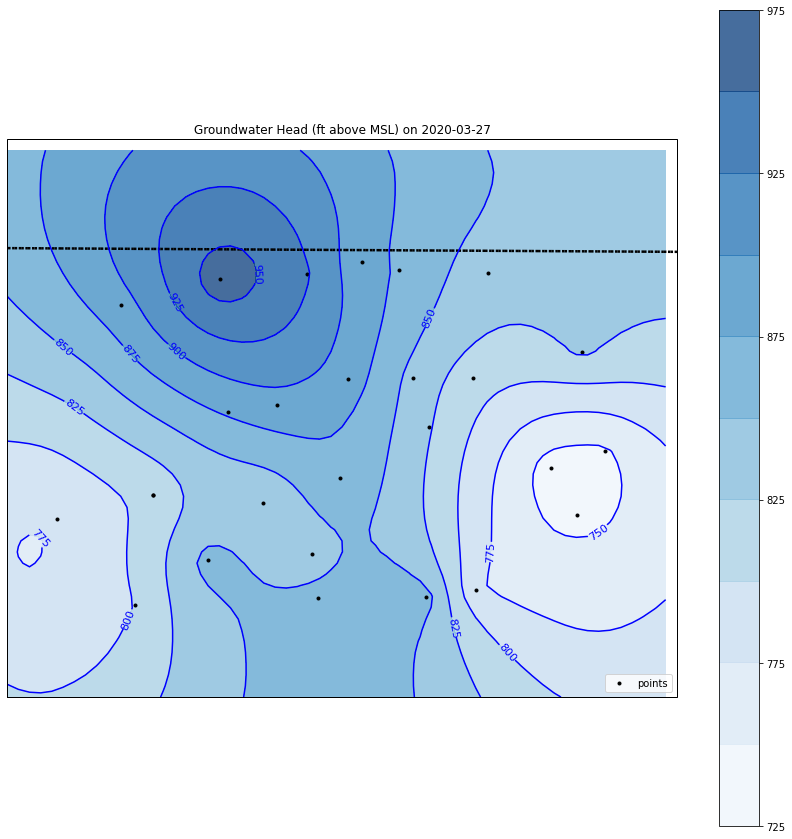

In [62]:
create_map(recent_df)

In [63]:
hist_url='&period=P200D&parameterCd=72019&siteStatus=all'
hist_df=compile_data(hist_url)

                                                   SiteName  ...    Head
SiteNum                                                      ...        
421056088380801                    43N5E-27.4h1 (14-RIL-S)   ...  797.84
421120088281801                   43N7E-19.8d (HUNT-09-03)   ...  850.93
421122088222702                    43N7E-23.1d2 (16-GRF-D)   ...  858.36
421145088194802                    43N8E-20.6h2 (17-ALG-D)   ...  784.69
421321088341101                   43N6E-07.1g (MARS-09-01)   ...  856.16
421341088283703                    43N6E-01.3b3 (15-COR-D)   ...  841.40
421533088421801   44N5E-30.8c1 (10-MAR-S) (McHenry Co CRN)   ...  774.86
421547088142301                   44N9E-25.1d (WAUC-02-12)   ...  744.68
421626088311401                    44N6E-22.4c1 (11-SEN-I)   ...  825.84
421653088370901                   44N5E-23.5g (MARN-09-02)   ...  808.82
421653088370902                  44N5E-23.5g2 (MARN-10-03)   ...  801.42
421747088270701                  44N7E-17.8h1 (WOOD

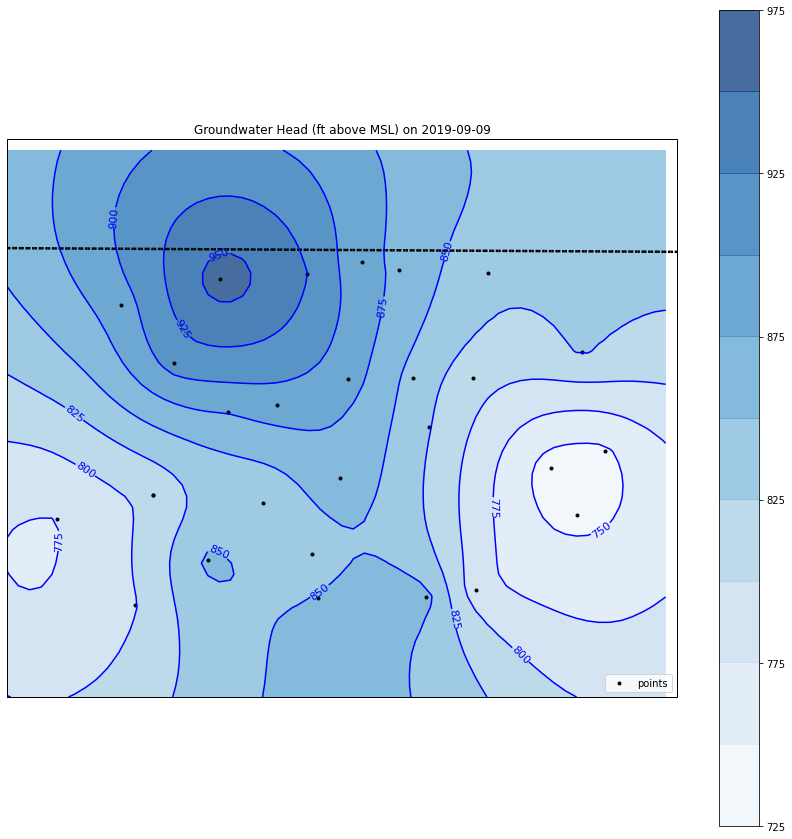

In [64]:
create_map(hist_df)


### <center>Part III: Comparison with a 2013 study</center>

Conduct a qualitative analysis on the potentiometric surface generated in this assignment with the potentiometric surface generated in a 2013 study (see page 71, Figure 42 of the following report: https://www.ideals.illinois.edu/handle/2142/50040). Write a paragraph discussing these differences (qualitatively). Include an image of Figure 42 in your Jupyter Notebook, with a reference to the report.
  
![](https://github.com/yiquanw2/geol572_6/blob/master/20200327221110.png?raw=true)